In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.optimize import curve_fit
from lmfit import Model
import matplotlib.gridspec as gridspec
from cmath import rect
import control
import math
import pylab
pylab.rcParams['figure.figsize'] = 10, 10

### RC Model

In [2]:
def bodecar (f, R_ohm, R_TE, C_TE):
    # H = R_ohm + R_TE/(C_TE*R_TE*s+1)
    # H = signal.lti([R_ohm*R_TE*C_TE,R_ohm+R_TE], [C_TE*R_TE, 1])
    num = [R_ohm*R_TE*C_TE, R_ohm+R_TE]
    den = [C_TE*R_TE, 1]
    H = signal.TransferFunction(num, den)
    # returned phase is in deg
    w, mag, phase = signal.bode(H, [2*np.pi*freq for freq in f]) # Hz to rad/s
    mag = [10**(dBmag/20) for dBmag in mag]
    nprect = np.vectorize(rect)
    X_jY = nprect(mag, np.deg2rad(phase))
    real_part = np.real(X_jY)
    imag_part = np.imag(X_jY)
    return np.stack([real_part/max(X), imag_part/max(Y)], axis=-1)

In [3]:
def bodepol (f, R_ohm, R_TE, C_TE):
    num = [R_ohm*R_TE*C_TE, R_ohm+R_TE]
    den = [C_TE*R_TE, 1]
    H = signal.TransferFunction(num, den)
    w, mag, phase = signal.bode(H, [2*np.pi*freq for freq in f])
    mag = [10**(dBmag/20) for dBmag in mag]
    phase = np.deg2rad(phase)
    return np.stack([mag, phase], axis=-1)

### Parse and trim datafile

In [4]:
def parse_data (datfilename, freqLB=100, freqUB=100000):

    freq = []
    V = []
    Pd = []

    lines = open(datfilename, 'r', encoding='UTF-8')
    
    for line in lines:
        if line[0] != ",":
            numbers = line.split(",")
            f = float(numbers[0])
            if f > freqUB or f < freqLB:
                continue
            freq.append(f)
            V.append(float(numbers[1]))
            Pd.append(float(numbers[2]))
    
    X = []
    Y = []
    Pmin = min(Pd)
    for magnitude, phase, f in zip(V, Pd, freq):
        real = magnitude * np.cos(phase*np.pi/180)
        img = magnitude * np.sin(phase*np.pi/180)
        X.append(real)
        Y.append(img)
        if Pmin == phase:
            est_f_TE = f
                
    return np.array(V), np.array(Pd), np.array(X), np.array(Y), np.array(freq), est_f_TE

In [ ]:
V, Pd, X, Y, freq, est_f_TE = parse_data("TEMPSWEEP_0523/C24.csv", freqLB=100, freqUB=20e3)
fig, ax1 = plt.subplots(1)
ax2 = ax1.twinx()
ax1.set_xlabel('Frequency (Hz)')
plt.xscale('log')
color = 'tab:brown'
ax1.set_ylabel('Magnitude (Ohm)', color=color)
ax1.plot(freq, V, marker='$.$', color=color, alpha=0.2, linestyle='None', label='data')
ax2.plot(freq, Pd, marker='.', color="tab:green", alpha=0.2, linestyle='None', label='data')

#### Optimizers

’leastsq’: Levenberg-Marquardt (default)

’least_squares’: Least-Squares minimization, using Trust Region Reflective method

’differential_evolution’: differential evolution

’brute’: brute force method

’basinhopping’: basinhopping

’ampgo’: Adaptive Memory Programming for Global Optimization

’nelder’: Nelder-Mead

’lbfgsb’: L-BFGS-B

’powell’: Powell

’cg’: Conjugate-Gradient

’newton’: Newton-CG

’cobyla’: Cobyla

’bfgs’: BFGS

’tnc’: Truncated Newton

’trust-ncg’: Newton-CG trust-region

’trust-exact’: nearly exact trust-region

’trust-krylov’: Newton GLTR trust-region

’trust-constr’: trust-region for constrained optimization

’dogleg’: Dog-leg trust-region

’slsqp’: Sequential Linear Squares Programming

’emcee’: Maximum likelihood via Monte-Carlo Markov Chain

’shgo’: Simplicial Homology Global Optimization

’dual_annealing’: Dual Annealing optimization

In [7]:
def fit_data(X, Y, est_f_TE, confidence = 1.5, 
             minimizer = "least_squares", reffunc = bodecar, alias = ''):
        
        # initial guess
        est_R_ohm = min(X)
        est_R_TE = max(X)-est_R_ohm
        est_C_TE = 1/(est_f_TE*2*np.pi)/est_R_TE
        #print(est_R_ohm, est_R_TE)

        # pass 1d array to avoid complex part being trimmed by scipy
        X_jY = np.zeros_like(X, dtype=np.complex)
        X_jY = np.array([x+1j*y for (x, y) in zip(X,Y)])
        X_jY_flattened = np.stack([np.real(X_jY), np.imag(X_jY )], axis=-1)
        
        bode_model = Model(reffunc)
        bode_model.set_param_hint('C_TE', value=est_C_TE, min=est_C_TE/confidence,max=est_C_TE*confidence)
        bode_model.set_param_hint('R_ohm', value=est_R_ohm, min=est_R_ohm/confidence,max=est_R_ohm*confidence)
        bode_model.set_param_hint('R_TE', value=est_R_TE, min=est_R_TE/confidence,max=est_R_TE*confidence)
        
        params = bode_model.make_params(R_ohm = est_R_ohm, R_TE=est_R_TE, C_TE=est_C_TE)
        
        print('-'*30 + alias + '-'*30)
        print("[[Minimizer]] = {}".format(minimizer))
        Z_fit_obj = bode_model.fit(X_jY_flattened, params, f=freq, method=minimizer) 
        
        initial_fit = Z_fit_obj.init_fit
        nprect = np.vectorize(rect)
        if ("pol" in reffunc.__name__):
            phase = initial_fit[:, 1]
            #phase = np.deg2rad(phase)
            initial_fit = nprect(initial_fit[:, 0], phase)
        else:
            initial_fit = initial_fit[:, 0]*max(X) + 1j*initial_fit[:, 1]*max(Y)
            
        Z_fit = Z_fit_obj.best_fit    
        if ("pol" in reffunc.__name__):
            phase = Z_fit[:, 1]
            #phase = np.deg2rad(phase)
            Z_fit = nprect(Z_fit[:, 0], phase)
        else:
            Z_fit = Z_fit[:, 0]*max(X) + 1j*Z_fit[:, 1]*max(Y)
        print(Z_fit_obj.fit_report())
        
        
        est_R_ohm = Z_fit_obj.params['R_ohm'].value
        est_R_TE = Z_fit_obj.params['R_TE'].value
        est_C_TE = Z_fit_obj.params['C_TE'].value
        est_f_TE=1/2/np.pi/est_R_TE/est_C_TE
        mse = (np.abs(Z_fit - X_jY)**2).mean()
        
        print('[[Predictions]]')
        print('zT = R_TE/R_ohm = '+str(est_R_TE/est_R_ohm))
        print('R_ohm = {}'.format(est_R_ohm))
        print('R_TE = {}'.format(est_R_TE))
        print('C_TE = {}'.format(est_C_TE))
        print('f_TE = '+str(est_f_TE))
        print('f lim -> 0 dashed line = est_R_ohm+est_R_TE = '+str((est_R_ohm+est_R_TE)))
        print('f lim -> inf dashed line = est_R_ohm ='+str(est_R_ohm))
        print(f'MSE = {mse}')
        
        return Z_fit, initial_fit, est_R_ohm, est_R_TE, est_C_TE, est_f_TE, mse
        


In [ ]:
Z_fit, initial_fit, est_R_ohm, est_R_TE, est_C_TE, est_f_TE, mse = fit_data(X, Y, np.exp(7.5692), 
                                                                      confidence = 1.0005,
                                                                      reffunc = bodecar,
                                                                      minimizer = "cg")#'least_squares', 'cg'

In [9]:
#%matplotlib inline
def plot_bode(fit, colorM='maroon', colorP='green', show_fTE=False):
    fig, ax1 = plt.subplots(1)
    ax2 = ax1.twinx()
    ax1.set_xlabel('Frequency (Hz)')
    plt.xscale('log')
    
    ax1.set_ylabel('Magnitude (Ohm)')

    if show_fTE: 
        ax1.axhline(y=est_R_ohm, dashes=[3, 1], color='0.8', xmin=0.75, xmax=1)
        ax1.axhline(y=est_R_ohm+est_R_TE, dashes=[3, 1], color='0.8', xmin=0, xmax=0.25)
        ax1.axvline(x=est_f_TE, dashes=[3, 1], color='0.6')
    ax1.plot(freq, V, marker='$.$', color=colorM, alpha=0.2, linestyle='None')
    ax1.plot(freq, np.abs(Z_fit), color=colorM)
    ax1.tick_params(axis='y', labelcolor=colorM)
    ax2.set_ylabel('Phase (deg)')

    ax2.plot(freq, Pd, marker='.', color=colorP, alpha=0.2, linestyle='None')
    ax2.plot(freq, np.angle(Z_fit, deg=True), dashes=[4, 1], color=colorP)
    ax2.tick_params(axis='y')
    #fig.tight_layout()
    ax1.set_title('Impedance spectrum')


------------------------------297K------------------------------
[[Minimizer]] = cg
[[Model]]
    Model(bodecar)
[[Fit Statistics]]
    # fitting method   = CG
    # function evals   = 371
    # data points      = 152
    # variables        = 3
    chi-square         = 4366.59399
    reduced chi-square = 29.3059999
    Akaike info crit   = 516.394424
    Bayesian info crit = 525.466066
[[Variables]]
    R_ohm:  0.00447082 +/- 4.9923e-08 (0.00%) (init = 0.004473054)
    R_TE:   1.9161e-04 +/- 4.3430e-11 (0.00%) (init = 0.0001917044)
    C_TE:   0.42826169 +/- 1.1388e-04 (0.03%) (init = 0.4284758)
[[Predictions]]
zT = R_TE/R_ohm = 0.04285760271975672
R_ohm = 0.004470818827428301
R_TE = 0.0001916085771379307
C_TE = 0.4282616879858827
f_TE = 1939.5275876412393
f lim -> 0 dashed line = est_R_ohm+est_R_TE = 0.0046624274045662314
f lim -> inf dashed line = est_R_ohm =0.004470818827428301
MSE = 7.47197111096201e-11
------------------------------307K------------------------------
[[Minimizer]] 

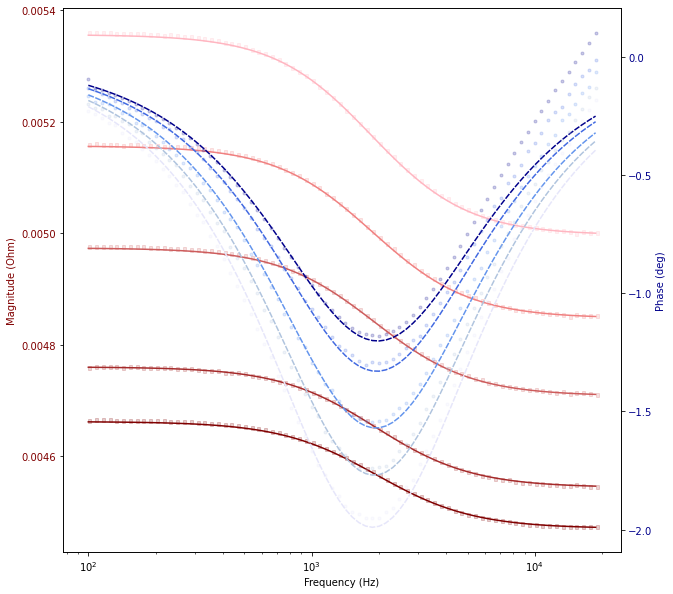

In [10]:
temps = [24, 34, 56, 74, 92]
ftes = np.exp([7.5692,7.55553,7.54186,7.52135,7.5027])
colorMs = ['maroon', 'brown', 'indianred', 'lightcoral', 'lightpink']
colorPs = ['darkblue', 'royalblue', 'cornflowerblue', 'lightsteelblue', 'lavender']
colorMPs = ['maroon', 'peru', 'olivedrab', 'teal', 'darkslateblue']
allinone = True
pylab.rcParams['figure.figsize'] = 10, 10

if allinone:
    fig, ax1 = plt.subplots(1)
    ax2 = ax1.twinx()
    ax1.set_xlabel('Frequency (Hz)')
    plt.xscale('log')
    ax1.set_ylabel('Magnitude (Ohm)', color=colorMs[0])
    ax2.set_ylabel('Phase (deg)', color=colorPs[0])
    ax1.tick_params(axis='y', labelcolor=colorMs[0])
    ax2.tick_params(axis='y', labelcolor=colorPs[0])

for idx, (t, fte, cm, cp) in enumerate(zip(temps, ftes, colorMs, colorPs)):
    V, Pd, X, Y, freq, _ = parse_data(f'TEMPSWEEP_0523/C{t}.csv', freqLB=100, freqUB=20e3)
    Z_fit, _, est_R_ohm, est_R_TE, est_C_TE, est_f_TE, mse = fit_data(X, Y, fte, 
                                                                      confidence = 1.0005,
                                                                      reffunc = bodecar,
                                                                      minimizer = "cg",
                                                                      alias = f'{t+273}K')#'least_squares', 'cg'
    
    if not allinone:
        plot_bode(Z_fit, colorM=cm, colorP=cp)
    else:
        ax1.plot(freq, V, marker='$.$', color=cm, alpha=0.2, linestyle='None')
        ax1.plot(freq, np.abs(Z_fit), color=cm)
        ax2.plot(freq, Pd, marker='.', color=cp, alpha=0.2, linestyle='None')
        ax2.plot(freq, np.angle(Z_fit, deg=True), dashes=[4, 1], color=cp)
    
